In [110]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torchvision
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import os

import math, random
from tqdm import tqdm

In [112]:
# from google.colab import drive
# drive.mount('/content/drive')

In [113]:
# %cd /content/drive/MyDrive/Georgia_Tech/MS_Fall_2023/DL/Group Project/birdcelf-2023-unzipped
# !unzip "/content/drive/MyDrive/Georgia_Tech/MS_Fall_2023/DL/Group Project/birdclef-2023.zip"

In [114]:
# %cd '/content/drive/MyDrive/Georgia_Tech/MS_Fall_2023/DL/Group Project'
# %pwd

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [116]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [117]:
class CFG:
    isOneHot = False
    rate = 32000
    num_classes = 264

In [118]:
sig, sr = torchaudio.load('/birdclef-2023/train_audio/abethr1/XC128013.ogg')
print('shape:',sig.shape)
print('rate:', sr)

shape: torch.Size([1, 1459513])
rate: 32000


In [119]:
class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      return aud

    if (new_channel == 1):
      resig = sig[:1, :]
    else:
      resig = torch.cat([sig, sig, sig])

    return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      return aud

    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      sig = torch.cat((pad_begin, sig, pad_end), 1)
    return (sig, sr)

  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    return aug_spec

In [120]:
meta_df = pd.read_csv('/birdclef-2023/train_metadata.csv')
print('data shape:',meta_df.shape)
meta_df.head()

data shape: (16941, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [123]:
if CFG.isOneHot:
    label = OneHotEncoder(sparse=False)\
                                    .fit_transform(meta_df['primary_label'].to_numpy().reshape(-1,1))
    meta_df['label'] = pd.DataFrame(label).apply(lambda x: list(x), axis = 1)
else:
    meta_df['label'] = LabelEncoder().fit_transform(meta_df['primary_label'])
meta_df.head(2)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0


In [124]:
def cv_split(Xtrain, ytrain, n_folds, seed):
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for num, (train_index, val_index) in enumerate(kfold.split(Xtrain, ytrain)):
        Xtrain.loc[val_index, 'fold'] = int(num)
    Xtrain['fold'] = Xtrain['fold'].astype(int)
    return Xtrain
meta_df = cv_split(meta_df,meta_df['primary_label'], 5, 42)
meta_df.head(6)




/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label,fold
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0,3
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0,3
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg,0,0
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg,0,4
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg,0,1
5,abethr1,['rbsrob1'],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/379322,abethr1/XC379322.ogg,0,2


In [125]:
class SoundDS(Dataset):
  def __init__(self, df, data_path ='/birdclef-2023/train_audio/', mode='train'):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 8000
    self.sr = 32000
    self.channel = 3
    self.shift_pct = 0.4
    self.mode = mode

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename']
    class_id = np.array(self.df.loc[idx, 'label'])
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)
    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    if self.mode == 'train':
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        return aug_sgram, class_id
    else:
        shift_aud = dur_aud
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        return sgram, class_id


In [126]:
train_ds = SoundDS(meta_df[meta_df.fold != 0].reset_index(), mode='train')
test_ds = SoundDS(meta_df[meta_df.fold == 0].reset_index(), mode='test')
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True)

print('train samples ', meta_df[meta_df.fold != 0].shape)
print('test samples ', meta_df[meta_df.fold == 0].shape)

train samples  (13552, 14)
test samples  (3389, 14)


In [127]:
a,b = next(iter(train_dl))
print(a.shape)
print(b.shape)

torch.Size([16, 3, 64, 501])
torch.Size([16])


In [128]:
# model = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights.DEFAULT, progress=True)

# # print(vars(model))
# model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
# model.classifier = nn.Sequential(nn.Flatten(),
#                                  nn.Linear(1792, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(256, CFG.num_classes),
#                                 )
# # num_features = model._fc.in_features
# # model._fc = nn.Linear(num_features, CFG.num_classes)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# myModel = model.to(device)
# next(myModel.parameters()).device

In [129]:


# def training(model, train_dl, num_epochs):
#   # Loss Function, Optimizer and Scheduler
#   criterion = nn.CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#   scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
#                                                 steps_per_epoch=int(len(train_dl)),
#                                                 epochs=num_epochs,
#                                                 anneal_strategy='linear')


#   best_acc = -1
#   for epoch in range(num_epochs):
#     running_loss = 0.0
#     correct_prediction = 0
#     total_prediction = 0


#     for i, data in enumerate(train_dl):
#         inputs, labels = data[0].to(device), data[1].to(device)


#         inputs_m, inputs_s = inputs.mean(), inputs.std()
#         inputs = (inputs - inputs_m) / inputs_s

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         running_loss += loss.item()


#         _, prediction = torch.max(outputs,1)
#         # Count of predictions that matched the target label
#         correct_prediction += (prediction == labels).sum().item()
#         total_prediction += prediction.shape[0]

#         if (i + 1) % 1 == 0:    
#            print('Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}'
#             .format(epoch + 1, num_epochs, i + 1, len(train_dl), running_loss/(i + 1)))


#     num_batches = len(train_dl)
#     avg_loss = running_loss / num_batches
#     acc = correct_prediction/total_prediction
#     print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

#     if (best_acc < acc):
#         best_acc = acc
#         print("Saving best model!")
#         torch.save(model.state_dict(), f'BirdSound_EfficientNet_B4_epoch{epoch}.pth')

#   print('Finished Training')

# num_epochs = 15   
# training(myModel, train_dl, num_epochs)

In [130]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
def testing_enet(model, test_dl):
    criterion = nn.CrossEntropyLoss()
    gt = torch.tensor([])
    pred = torch.tensor([])
    gt = gt.to(device)
    pred = pred.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for idx, data_ in enumerate(test_dl):
            inputs, labels = data_[0].to(device), data_[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            print(outputs.shape)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            max_values, prediction = torch.max(outputs,1)

            predi = torch.softmax(outputs, dim = -1)

            gt = torch.cat((gt, labels), dim = 0)

            pred = torch.cat((pred, prediction), dim = 0)
            correct += (prediction == labels).sum().item()
            total += prediction.shape[0]

        gt = gt.to('cpu')
        pred = pred.to('cpu')

        precision = precision_score(gt, pred, average='weighted',  zero_division=0)
        recall = recall_score(gt, pred, average='weighted', zero_division=0)
        f1 = f1_score(gt, pred, average='weighted', zero_division=0)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        final_score = 100 * correct / total
        print("Final Test Accuracy", final_score)

def testing_resnet(model, test_dl):
    criterion = nn.CrossEntropyLoss()
    gt = []
    pred = []
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for idx, data_ in enumerate(test_dl):
            inputs, labels = data_[0].to(device), data_[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = model(inputs)
            print(outputs.shape)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, prediction = torch.max(outputs,1)
            predi = torch.softmax(outputs, dim = -1)
            gt.append(labels)
            pred.append(predi[:,1])
            correct += (prediction == labels).sum().item()
            total += prediction.shape[0]

        final_score = 100 * correct / total
        print("Final Test Accuracy", final_score)

In [131]:
resnet34_model_path = '/ensemble-rnet34-enetb4-v1/BirdSound_MobileNetV2_fold0_epoch14.pth'
checkpoint_resnet34 = torch.load(resnet34_model_path)
model_resnet = torchvision.models.resnet34(pretrained=True)
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, CFG.num_classes)
model_resnet.to(device)
model_resnet.load_state_dict(checkpoint_resnet34)
model_resnet.eval()


enet_model_path = '/ensemble-rnet34-enetb4-v1/BirdSound_EfficientNet_B4_epoch14.pth'
checkpoint_enet = torch.load(enet_model_path)
model_enet = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights.DEFAULT, progress=True)
model_enet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model_enet.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(1792, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, CFG.num_classes),
                                )
model_enet = model_enet.to(device)
next(model_enet.parameters()).device
model_enet.load_state_dict(checkpoint_enet)
model_enet.eval()
# testing_enet(model_enet, test_dl)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [132]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(264 * 2, 264)

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_resnet, model_enet)

for param in ensemble_model.parameters():
    param.requires_grad = False
for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(device)

In [133]:
import copy
import matplotlib.pyplot as plt
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(device)
                        targets = targets.to(device)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(device)
                        targets = targets.to(device)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.001]


 14%|█▍        | 1/7 [23:13<2:19:20, 1393.37s/it]

	| New lowest val loss for Ensemble: 9.470605787073055
Epoch: 2 | Learning rate: [0.001]


 29%|██▊       | 2/7 [42:58<1:45:55, 1271.10s/it]

	| New lowest val loss for Ensemble: 8.658246640894816
Epoch: 3 | Learning rate: [0.001]


 43%|████▎     | 3/7 [1:02:36<1:21:54, 1228.64s/it]

Epoch: 4 | Learning rate: [0.0001089]


 57%|█████▋    | 4/7 [1:22:13<1:00:24, 1208.16s/it]

	| New lowest val loss for Ensemble: 4.499548740713054
Epoch: 5 | Learning rate: [0.00033]


 71%|███████▏  | 5/7 [1:41:40<39:46, 1193.07s/it]  

	| New lowest val loss for Ensemble: 4.412982841901699
Epoch: 6 | Learning rate: [0.00033]


 86%|████████▌ | 6/7 [2:00:54<19:40, 1180.09s/it]

	| New lowest val loss for Ensemble: 4.3438492166567615
Epoch: 7 | Learning rate: [3.5937000000000005e-05]


100%|██████████| 7/7 [2:20:11<00:00, 1201.65s/it]

	| New lowest val loss for Ensemble: 3.1571315409415033


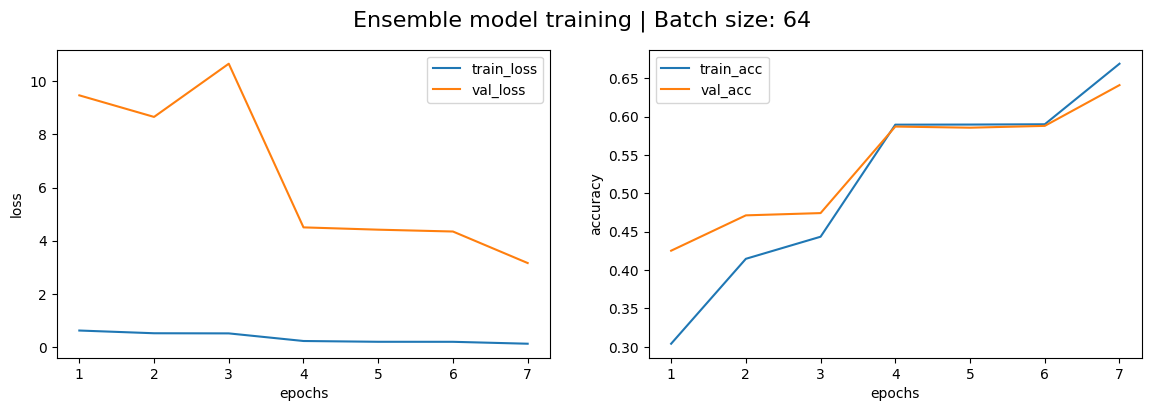


Training results:
	Min val loss 3.1571 was achieved during iteration #7
	Val accuracy during min val loss is 0.6409


In [134]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=7,
                                     train_dataloader=train_dl,
                                     val_dataloader=test_dl)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=7,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))